In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
from NeuralNetwork import NeuralNetwork, sigmoid
from Dense import Dense
from Conv import Conv
from Tensor import Tensor
import matplotlib.pyplot as plt

In [14]:
import numpy as np
from NeuralNetwork import NeuralNetwork, sigmoid
from Dense import Dense
from Conv import Conv
from Tensor import Tensor

model = NeuralNetwork([Conv((5,5),3,0,(12,12,3),(1,1),sigmoid),Conv((5,5),4,0,(7,7,3),(1,1),sigmoid),Dense(16,10,sigmoid)])
model.allocateMemory(1)
x = Tensor(np.random.randn(*(1,10,10,1)))
y = Tensor(np.random.randn(1,10))
model.gradientDescent(x,y,0)
dw,db = model.testGrads(x,y)

In [20]:
model.layers[1]

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]

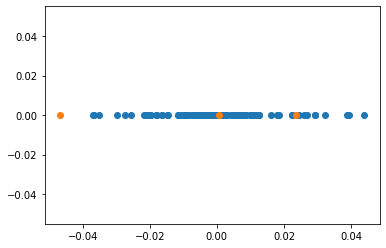

In [17]:
l = 0
plt.scatter(dw[l],model.layers[l].dw.get().flatten())
plt.scatter(db[l],model.layers[l].db.get().flatten())